In [1]:
import tensorflow as tf
from tensorflow import keras

**Compatibilidade com a versão 1 do tensorflow: Habilita recursos do tensorboard**




In [2]:
tf.compat.v1.disable_v2_behavior()

fashion_mnist=keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from sklearn.utils import resample
X_train_full, y_train_full = resample(X_train_full, y_train_full, n_samples=10000, random_state=0)

print (X_train_full.shape, X_train_full.dtype)

(10000, 28, 28) uint8


In [4]:
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.
print(X_train.shape)

(5000, 28, 28)


In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) 
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print(X_train.shape)

(5000, 28, 28, 1)


In [6]:
class_names=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [9]:
def create_model(hidden_layers=1, filter_size=16, filter_dim=(2,2), pool_size=(2,2)):
 
  # Initialize model
  tf.compat.v1.reset_default_graph()
  model = keras.models.Sequential()
  
  for i in range(hidden_layers):
      # Add conv layer
      model.add(keras.layers.Conv2D(filter_size*(i+1), filter_dim, padding="same", input_shape=(28, 28, 1), activation="relu"))
      # Add pool layer
      model.add(keras.layers.MaxPool2D(pool_size=pool_size))

  # Flatten layer
  model.add(keras.layers.Flatten())

  # Fully connected layer
  model.add(keras.layers.Dense(100, activation="relu"))

  # Output layer
  model.add(keras.layers.Dense(10, activation='softmax'))

  # Compile model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
  
  return model

In [10]:
cnn_model = create_model();
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               313700    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 314,790
Trainable params: 314,790
Non-trainable params: 0
__________________________________________________

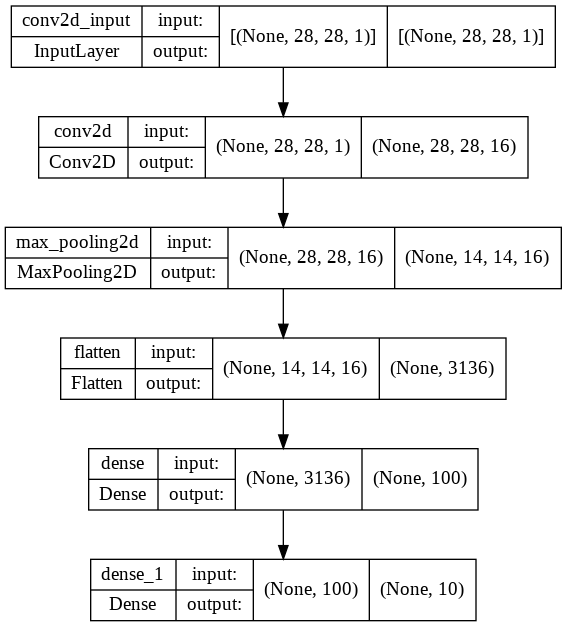

In [11]:
keras.utils.plot_model(cnn_model, "cnn_model.png", show_shapes=True)

In [12]:
# Create callbacks
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_acc', mode='max', patience=5, restore_best_weights=True)

from keras.callbacks import TensorBoard
%load_ext tensorboard
!rm -rf "tensorboard"
tensorboard_callback = TensorBoard(log_dir="tensorboard", histogram_freq=1,update_freq='epoch', write_grads=True)

In [13]:
#Train model
history = cnn_model.fit(X_train,y_train, epochs=30, validation_data=(X_valid,y_valid), callbacks=[tensorboard_callback, es])

Train on 5000 samples, validate on 5000 samples
Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5000/5000 [==============================] - 12s 2ms/sample - loss: 1.6487 - acc: 0.5084 - val_loss: 1.1192 - val_acc: 0.6340
Epoch 2/30
5000/5000 [==============================] - 9s 2ms/sample - loss: 0.9050 - acc: 0.6900 - val_loss: 0.8467 - val_acc: 0.7030
Epoch 3/30
5000/5000 [==============================] - 9s 2ms/sample - loss: 0.7257 - acc: 0.7526 - val_loss: 0.8006 - val_acc: 0.7036
Epoch 4/30
5000/5000 [==============================] - 9s 2ms/sample - loss: 0.6554 - acc: 0.7708 - val_loss: 1.0397 - val_acc: 0.6746
Epoch 5/30
5000/5000 [==============================] - 9s 2ms/sample - loss: 0.6176 - acc: 0.7844 - val_loss: 0.6942 - val_acc: 0.7440
Epoch 6/30
5000/5000 [==============================] - 9s 2ms/sample - loss: 0.5813 - acc: 0.7968 - val_loss: 0.6387 - val_acc: 0.7792
Epoch 7/30
5000/5000 [==============================] - 10s 2ms/sample - loss: 0.5666 - acc: 0.7988 - val_loss: 0.7847 - val_acc: 0.7480
Epoch 8/30
5000/5000 [==============================] - 9

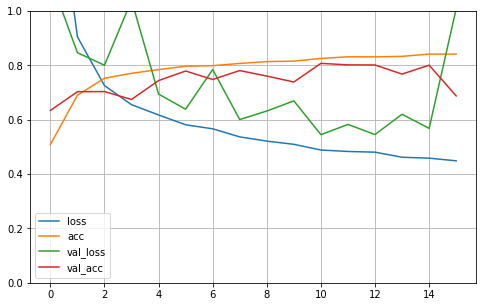

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [15]:
score = cnn_model.evaluate(X_test, y_test)

print('Test loss:', round(score[0], 2)) 
print('Test accuracy:', round(score[1], 2))

Test loss: 0.55
Test accuracy: 0.81


In [18]:
# Hyperparameter space
hidden_layers = [2, 3, 4, 5]
filter_size = [16, 32, 48, 64, 80]
filter_dim = [(2,2), (4,4), (6,6), (8,8)]
pool_size = [(3,3), (5,5), (7,7)]

param_grid = {
    'hidden_layers': hidden_layers,
    'filter_size': filter_size,
    'filter_dim': filter_dim,
    'pool_size': pool_size
}

In [17]:
# Wrap model
model = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [19]:
# Grid Search
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

# Fit grid search
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
900 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 155, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.b

Train on 5000 samples
5000/5000 [==============================] - 1s 166us/sample - loss: 1.7865 - acc: 0.4658
Best: 0.577800 using {'filter_dim': (8, 8), 'filter_size': 64, 'hidden_layers': 2, 'pool_size': (3, 3)}


In [37]:
# implement best model

best_model = create_model(hidden_layers=grid.best_params_['hidden_layers'],
                          filter_size = grid.best_params_['filter_size'],
                          filter_dim = grid.best_params_['filter_dim'],
                          pool_size = grid.best_params_['pool_size'])

best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        4160      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 128)         524416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

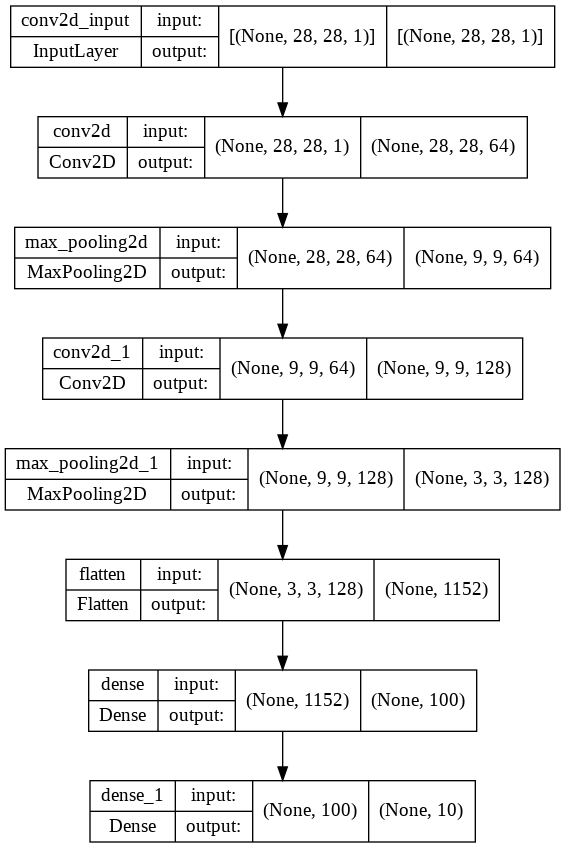

In [38]:
keras.utils.plot_model(best_model, "my_fashion_mnist_model.png", show_shapes=True)

In [35]:
from keras import backend as K
K.clear_session()

In [39]:
# Train the best model
history = best_model.fit(X_train,y_train, epochs=30, validation_data=(X_valid,y_valid), callbacks=[tensorboard_callback, es])

Train on 5000 samples, validate on 5000 samples
Epoch 1/30
 640/5000 [==>...........................] - ETA: 1s - loss: 2.2782 - acc: 0.1828

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5000/5000 [==============================] - 26s 5ms/sample - loss: 1.8658 - acc: 0.4562 - val_loss: 1.2819 - val_acc: 0.5216
Epoch 2/30
5000/5000 [==============================] - 26s 5ms/sample - loss: 1.0061 - acc: 0.6242 - val_loss: 1.0253 - val_acc: 0.6136
Epoch 3/30
5000/5000 [==============================] - 27s 5ms/sample - loss: 0.8239 - acc: 0.6912 - val_loss: 0.8920 - val_acc: 0.6532
Epoch 4/30
5000/5000 [==============================] - 27s 5ms/sample - loss: 0.7630 - acc: 0.7032 - val_loss: 0.8366 - val_acc: 0.6700
Epoch 5/30
5000/5000 [==============================] - 26s 5ms/sample - loss: 0.7170 - acc: 0.7302 - val_loss: 0.7779 - val_acc: 0.6930
Epoch 6/30
5000/5000 [==============================] - 26s 5ms/sample - loss: 0.6739 - acc: 0.7472 - val_loss: 0.9103 - val_acc: 0.6410
Epoch 7/30
5000/5000 [==============================] - 26s 5ms/sample - loss: 0.6452 - acc: 0.7608 - val_loss: 0.8643 - val_acc: 0.6560
Epoch 8/30
5000/5000 [==============================

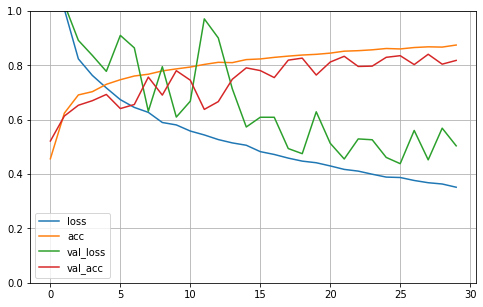

In [40]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [41]:
score = best_model.evaluate(X_test, y_test)

print('Test loss:', round(score[0], 2))
print('Test accuracy:', round(score[1], 2))

Test loss: 0.53
Test accuracy: 0.8
